# German Credit Risk 

Notebook using German Credit Risk Dataset from https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data and methods from paper: "Explainable AI for Credit Assessment in Banks" (https://www.mdpi.com/1911-8074/15/12/556). Some data preparation is based on https://github.com/alicenkbaytop/German-Credit-Risk-Classification/blob/master/german-credit-risk-classification.ipynb. 

Note that text for explanation in this notebook is for the most part copied/adapted from the paper above.

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Dataset


In [89]:
df = pd.read_csv('german_credit_data.csv')

In [90]:
print(df.head())

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  Risk  
0           1169         6             radio/TV  good  
1           5951        48             radio/TV   bad  
2           2096        12            education  good  
3           7882        42  furniture/equipment  good  
4           4870        24                  car   bad  


# Classification

In [91]:
df["Monthly pay"] = (df["Credit amount"] / df["Duration"])
df["Credit amount^2"] = df["Credit amount"]**2

In [92]:
df.insert(1,"Cat Age",np.NaN)
df.loc[df["Age"]<25,"Cat Age"]="0-25"
df.loc[((df["Age"]>=25) & (df["Age"]<30)),"Cat Age"]="25-30"
df.loc[((df["Age"]>=30) & (df["Age"]<35)),"Cat Age"]="30-35"
df.loc[((df["Age"]>=35) & (df["Age"]<40)),"Cat Age"]="35-40"
df.loc[((df["Age"]>=40) & (df["Age"]<50)),"Cat Age"]="40-50"
df.loc[((df["Age"]>=50) & (df["Age"]<76)),"Cat Age"]="50-75"

In [93]:
df.insert(9,"Cat Duration",df["Duration"])
for i in df["Cat Duration"]:
    if i<12:
        df["Cat Duration"]=df["Cat Duration"].replace(i,"0-12")
    elif (i>=12) and (i<24):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"12-24")
    elif (i>=24) and (i<36):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"24-36")
    elif (i>=36) and (i<48):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"36-48")
    elif (i>=48) and (i<60):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"48-60")
    elif (i>=60) and (i<=72):
        df["Cat Duration"]=df["Cat Duration"].replace(i,"60-72")

In [94]:
df.insert(4,"Cat Job",df["Job"])
df["Cat Job"]=df["Cat Job"].astype("category")
df["Cat Job"]=df["Cat Job"].replace(0,"unskilled")
df["Cat Job"]=df["Cat Job"].replace(1,"resident")
df["Cat Job"]=df["Cat Job"].replace(2,"skilled")
df["Cat Job"]=df["Cat Job"].replace(3,"highly skilled")

In [95]:
df["Job"]=pd.Categorical(df["Job"],categories=[0,1,2,3],ordered=True)
df["Cat Age"]=pd.Categorical(df["Cat Age"],categories=['0-25','25-30', '30-35','35-40','40-50','50-75'])
df["Cat Duration"]=pd.Categorical(df["Cat Duration"],categories=['0-12','12-24', '24-36','36-48','48-60','60-72'])

In [96]:
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,Cat Age,Age,Sex,Cat Job,Job,Housing,Saving accounts,Checking account,Credit amount,Cat Duration,Duration,Purpose,Risk,Monthly pay,Credit amount^2
0,50-75,67,male,skilled,2,own,NaN,little,1169,0-12,6,radio/TV,good,194.833333,1366561
1,0-25,22,female,skilled,2,own,little,moderate,5951,48-60,48,radio/TV,bad,123.979167,35414401
2,40-50,49,male,resident,1,own,little,NaN,2096,12-24,12,education,good,174.666667,4393216
3,40-50,45,male,skilled,2,free,little,little,7882,36-48,42,furniture/equipment,good,187.666667,62125924
4,50-75,53,male,skilled,2,free,little,little,4870,24-36,24,car,bad,202.916667,23716900


In [97]:
df = df.dropna()
df.head()

,Cat Age,Age,Sex,Cat Job,Job,Housing,Saving accounts,Checking account,Credit amount,Cat Duration,Duration,Purpose,Risk,Monthly pay,Credit amount^2
1,0-25,22,female,skilled,2,own,little,moderate,5951,48-60,48,radio/TV,bad,123.979167,35414401
3,40-50,45,male,skilled,2,free,little,little,7882,36-48,42,furniture/equipment,good,187.666667,62125924
4,50-75,53,male,skilled,2,free,little,little,4870,24-36,24,car,bad,202.916667,23716900
7,35-40,35,male,highly skilled,3,rent,little,moderate,6948,36-48,36,car,good,193.000000,48274704
9,25-30,28,male,highly skilled,3,own,little,moderate,5234,24-36,30,car,bad,174.466667,27394756


# Models

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,auc,classification_report

In [103]:
X=df.drop(["Risk"],axis=1)
Y=df["Risk"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

# Decision Tree

In [104]:
from sklearn.tree import DecisionTreeClassifier
cart_model=DecisionTreeClassifier(criterion='gini',max_depth=4,min_samples_leaf=54,min_samples_split=2).fit(X_train,Y_train)

print("Train Accuracy Score : ",accuracy_score(Y_train,cart_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,cart_model.predict(X_test)))

Importance=pd.DataFrame({"Values":cart_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

ValueError: could not convert string to float: '25-30'

# Gradient Boosting Decision Trees

Ensemble methods combine several learners to obtain better predictive performance than a single constituent learning algorithm. The ensemble method used in this study is boosting, where learners are trained on misclassified instances from the previous learners. Thus, several weak learners are combined into one strong learner. With weak learners, we mean models whose performance is slightly better than random chance. The advantages of using weak learners are outlined in Freund and Schapire (1995) and can be summarized as being computationally simple, with the ability to reduce overfitting and bias (Bartlett et al. 1998). Gradient Boosting Decision Trees (GBDT) utilize the boosting technique by sequentially training decision trees based on the residuals from the previous trees. See Zhang et al. (2017) for more details on the GBDT model.

Train Accuracy Score :  0.8385714285714285
Test Accuracy Score :  0.74


<Axes: >

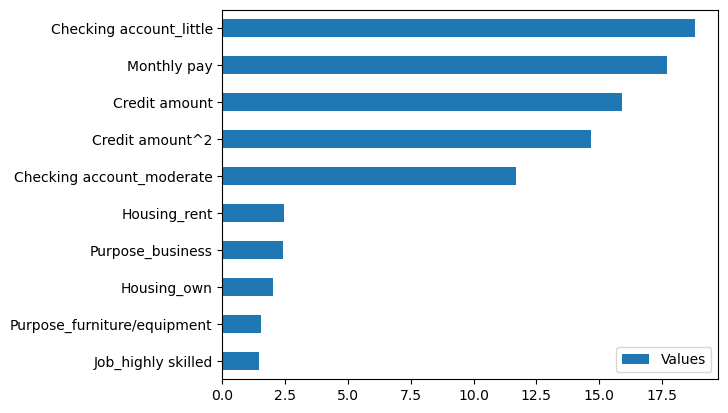

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(learning_rate = 0.01,max_depth = 5,min_samples_split = 10,n_estimators = 100).fit(X_train, Y_train)

print("Train Accuracy Score : ",accuracy_score(Y_train,gbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,gbm_model.predict(X_test)))

Importance=pd.DataFrame({"Values":gbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

Train Accuracy Score :  0.8985714285714286
Test Accuracy Score :  0.76


<Axes: >

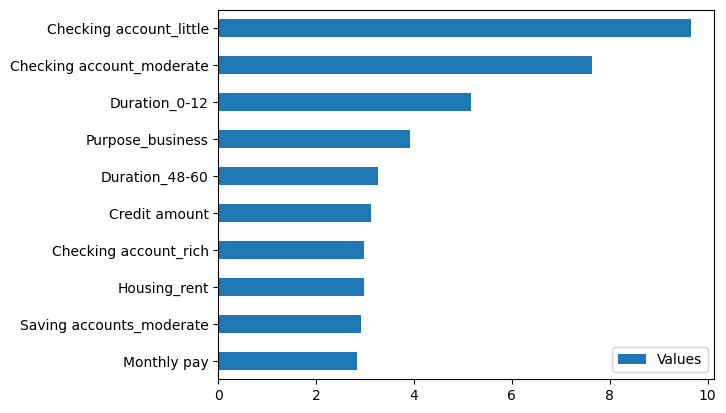

In [22]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate = 0.05, max_depth = 5,n_estimators=100,subsample=0.8).fit(X_train,Y_train)

print("Train Accuracy Score : ",accuracy_score(Y_train,xgb_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,xgb_model.predict(X_test)))

Importance=pd.DataFrame({"Values":xgb_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

# Light GBM

One of the limitations of traditional GBDT methods, such as AdaBoost (Freund and Schapire 1999) and XGBoost (Chen and Guestrin 2016), is the time-consuming process of iterating through all the data in order to estimate the information gain for all possible splits (Quinto 2020). Light Gradient Boosting Machine (LightGBM) is a variant of GBDT designed to be significantly faster than conventional GBDT techniques without sacrificing accuracy. This is done by implementing Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) (Ke et al. 2017). GOSS exploits that the information gain for instances with larger gradients (undertrained instances) is higher. By randomly dropping instances with smaller gradients, and to a larger extent keeping instances with larger gradients, the number of instances used for training can be reduced without sacrificing the accuracy in information gain estimation used for feature splitting in GBDT. EFB exploits sparse data by bundling mutually exclusive features into a single feature. These two improvements significantly improve the computational speed and memory consumption of LightGBM, making it state-of-the-art for many applications (Ke et al. 2017).

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 486, number of negative: 214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.694286 -> initscore=0.820233
[LightGBM] [Info] Start training from score 0.820233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

<Axes: >

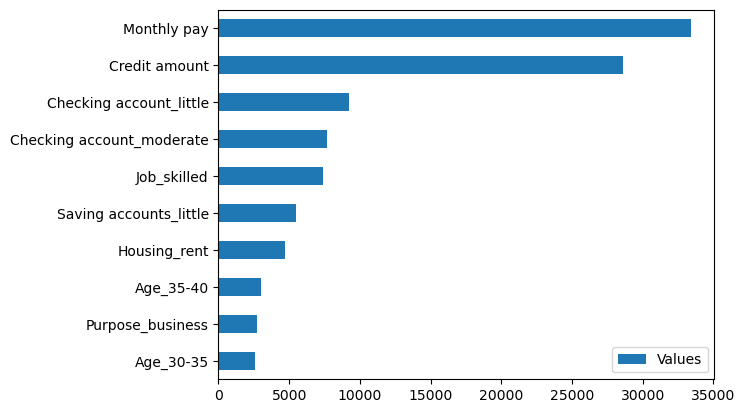

In [34]:
from lightgbm import LGBMClassifier
lgbm_model=LGBMClassifier(learning_rate=0.02,max_depth=3,min_child_samples=10,n_estimators=200,subsample=0.6).fit(X_train,Y_train)

print("Train Accuracy Score : ",accuracy_score(Y_train,lgbm_model.predict(X_train)))
print("Test Accuracy Score : ",accuracy_score(Y_test,lgbm_model.predict(X_test)))

Importance=pd.DataFrame({"Values":lgbm_model.feature_importances_*100},index=list(X_test.columns))
Importance.sort_values("Values",inplace=True,ascending=True)
Importance[28:].plot.barh()

In [53]:
import shap
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X)

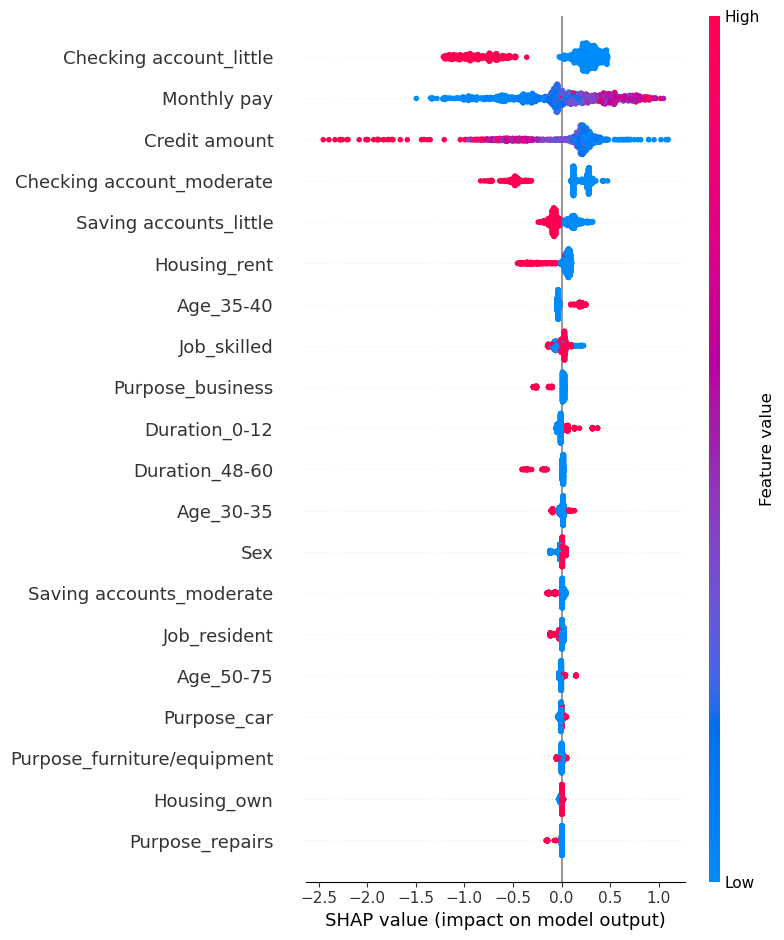

In [54]:
shap.summary_plot(shap_values, X)